# Mean variance optimization solution

For assignment and data, see https://www.fransderuiter.com/JADS/

***

### Setup

In [7]:
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
from matplotlib import cm

### Read data

In [8]:
data_path = "https://www.fransderuiter.com/JADS/Meanvariance/MeanVarPortfolio.xlsx"
# Create pandas table
df_input = pd.read_excel(data_path, sheet_name=0, header=1, skiprows=4, index_col=0)

# Show table
df_input.head()

,Unnamed: 1,Unnamed: 2,SMALL LoINV,ME1 INV2,ME1 INV3,ME1 INV4,ME1 INV5,ME1 INV6,ME1 INV7,ME1 INV8,...,BIG LoINV,ME10 INV2,ME10 INV3,ME10 INV4,ME10 INV5,ME10 INV6,ME10 INV7,ME10 INV8,ME10 INV9,BIG HiINV
SMALL LoINV,0.003369,2.301398,2.301398,2.075644,1.904954,1.873764,1.804488,1.760517,1.838048,1.898293,...,1.610037,1.971464,1.388215,1.478249,1.711632,1.394308,1.504389,1.754384,1.621627,1.613875
ME1 INV2,0.041349,2.154002,2.075644,2.154002,1.863827,1.842441,1.769529,1.726058,1.800831,1.846832,...,1.582968,1.925417,1.365061,1.471519,1.681836,1.376549,1.467429,1.737659,1.578213,1.559424
ME1 INV3,0.039155,1.892804,1.904954,1.863827,1.892804,1.724930,1.654159,1.611129,1.689768,1.724745,...,1.458070,1.782231,1.268083,1.349650,1.552639,1.277392,1.371330,1.610320,1.454294,1.418375
ME1 INV4,0.037095,1.879435,1.873764,1.842441,1.724930,1.879435,1.679332,1.610732,1.710631,1.742087,...,1.466828,1.853272,1.290937,1.367081,1.585465,1.301183,1.411083,1.672035,1.469236,1.461106
ME1 INV5,0.049750,1.760228,1.804488,1.769529,1.654159,1.679332,1.760228,1.558254,1.637907,1.668230,...,1.389965,1.712064,1.239707,1.312110,1.496432,1.228574,1.330135,1.573344,1.405970,1.383310


In [9]:
## Rename the first two columns

newcolumn_values = df_input.columns.values
newcolumn_values[0] = 'Mean'
newcolumn_values[1] = 'Variance'

df_input.columns = newcolumn_values

# Show table with removed column
df_input.head()

,Mean,Variance,SMALL LoINV,ME1 INV2,ME1 INV3,ME1 INV4,ME1 INV5,ME1 INV6,ME1 INV7,ME1 INV8,...,BIG LoINV,ME10 INV2,ME10 INV3,ME10 INV4,ME10 INV5,ME10 INV6,ME10 INV7,ME10 INV8,ME10 INV9,BIG HiINV
SMALL LoINV,0.003369,2.301398,2.301398,2.075644,1.904954,1.873764,1.804488,1.760517,1.838048,1.898293,...,1.610037,1.971464,1.388215,1.478249,1.711632,1.394308,1.504389,1.754384,1.621627,1.613875
ME1 INV2,0.041349,2.154002,2.075644,2.154002,1.863827,1.842441,1.769529,1.726058,1.800831,1.846832,...,1.582968,1.925417,1.365061,1.471519,1.681836,1.376549,1.467429,1.737659,1.578213,1.559424
ME1 INV3,0.039155,1.892804,1.904954,1.863827,1.892804,1.724930,1.654159,1.611129,1.689768,1.724745,...,1.458070,1.782231,1.268083,1.349650,1.552639,1.277392,1.371330,1.610320,1.454294,1.418375
ME1 INV4,0.037095,1.879435,1.873764,1.842441,1.724930,1.879435,1.679332,1.610732,1.710631,1.742087,...,1.466828,1.853272,1.290937,1.367081,1.585465,1.301183,1.411083,1.672035,1.469236,1.461106
ME1 INV5,0.049750,1.760228,1.804488,1.769529,1.654159,1.679332,1.760228,1.558254,1.637907,1.668230,...,1.389965,1.712064,1.239707,1.312110,1.496432,1.228574,1.330135,1.573344,1.405970,1.383310


### Model parameters

In [10]:
# Set with assets
assets = df_input.columns[2:] # first two columns are only mean and variance

# risk parameter
alpha = 0.012

### Model implementation

In [48]:
def MeanVarModelConstruction(alpha,df_input):
    # Create model
    m = ConcreteModel()

    # Variables
    m.amount = Var(assets, within = NonNegativeReals) # note that short sellings is not allowed, so we take the nonnegative reals as range

    # Objective
    m.value = Objective(
        expr=sum(m.amount[i]*df_input.loc[i,'Mean'] for i in assets)
        - alpha * sum(df_input.loc[i,j]*m.amount[i]*m.amount[j] for i in assets for j in assets)
        , sense = maximize
                 )
    # Constraints on budget
    m.budget = Constraint(expr=sum(m.amount[i] for i in assets) == 1)
        
    return m

### Solve the model

In [51]:
def OptimizeMeanVarModel(m,printResults):
    solver = SolverFactory('ipopt') # Take the ipopt solver for nonlinear problems
    status = solver.solve(m,tee=False,)

    if printResults:
        print("Risk aversion parameter = %s \n" % alpha)
        print("Status = %s \n" % status.solver.termination_condition)
    
    obj_opt = value(m.value)
    mean_opt = sum([value(m.amount[i]*df_input.loc[i,'Mean']) for i in assets])
    variance_opt = sum(df_input.loc[i,j]*value(m.amount[i])*value(m.amount[j]) for i in assets for j in assets)
    
    return (obj_opt, mean_opt, variance_opt)

### Solve and show the solution

In [52]:
# Construct model with chosen alpha
m = MeanVarModelConstruction(alpha,df_input)
# Optimize
obj_opt, mean_opt, variance_opt = OptimizeMeanVarModel(m,True)

print("Objective value model \t= %.3f" % obj_opt)
print("\t Mean return \t= %.3f" % mean_opt)
print("\t Variance \t= %.3f\n" % variance_opt)

print("Assets invested in (and amount):")
print("Portfolio composition:")
for i in assets:
    if value(m.amount[i] > 0.0001):
        print("\t"+ i + " : \t" + str(value(m.amount[i]))) 

Risk aversion parameter = 0.012 

Status = optimal 

Objective value model 	= 0.034
	 Mean return 	= 0.058
	 Variance 	= 2.005

Assets invested in (and amount):
Portfolio composition:
	ME1 INV5 : 	0.01851906452245525
	ME3 INV6 : 	0.1852226885759179
	ME5 INV2 : 	0.31113809379369767
	ME9 INV5 : 	0.4850844019007168


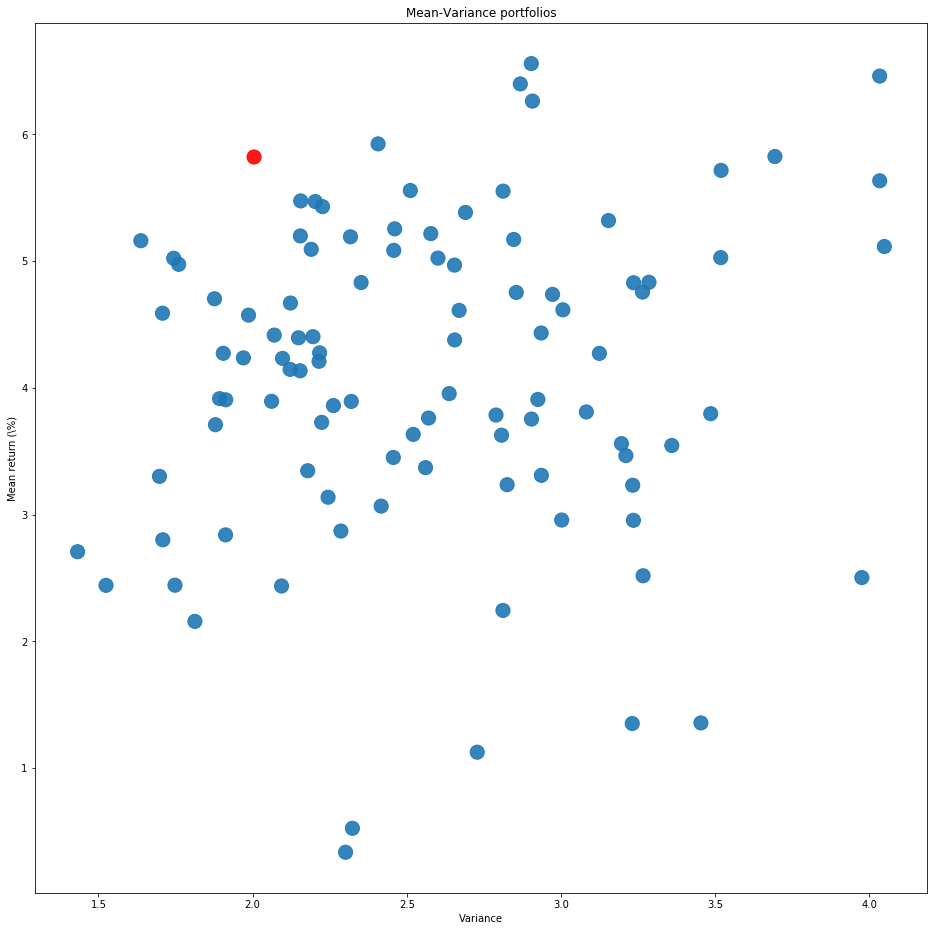

In [8]:
# Initialize plot
fig=plt.figure(figsize=(16,16))

# Plot mean returns and variances of individual assets
plt.scatter([df_input.loc[i,'Variance'] for i in assets], 
            [100*df_input.loc[i,'Mean'] for i in assets], 
            s = 200*np.ones(assets.size),
            alpha=0.9)
# Plot mean returns and variances of new optimal portfolio
plt.scatter(variance_opt, 
            100*mean_opt, 
            s = 200*np.ones(assets.size),
            c = 'red',
            alpha=0.9)

plt.title("Mean-Variance portfolios")
plt.xlabel("Variance")
plt.ylabel("Mean return (\%)")
plt.show()

### Show efficient frontier (not part of assignment)
The efficient frontier consists of all the mean-variance optimal portfolios. They are formed by varying the risk-aversion parameter alpha as shown below.

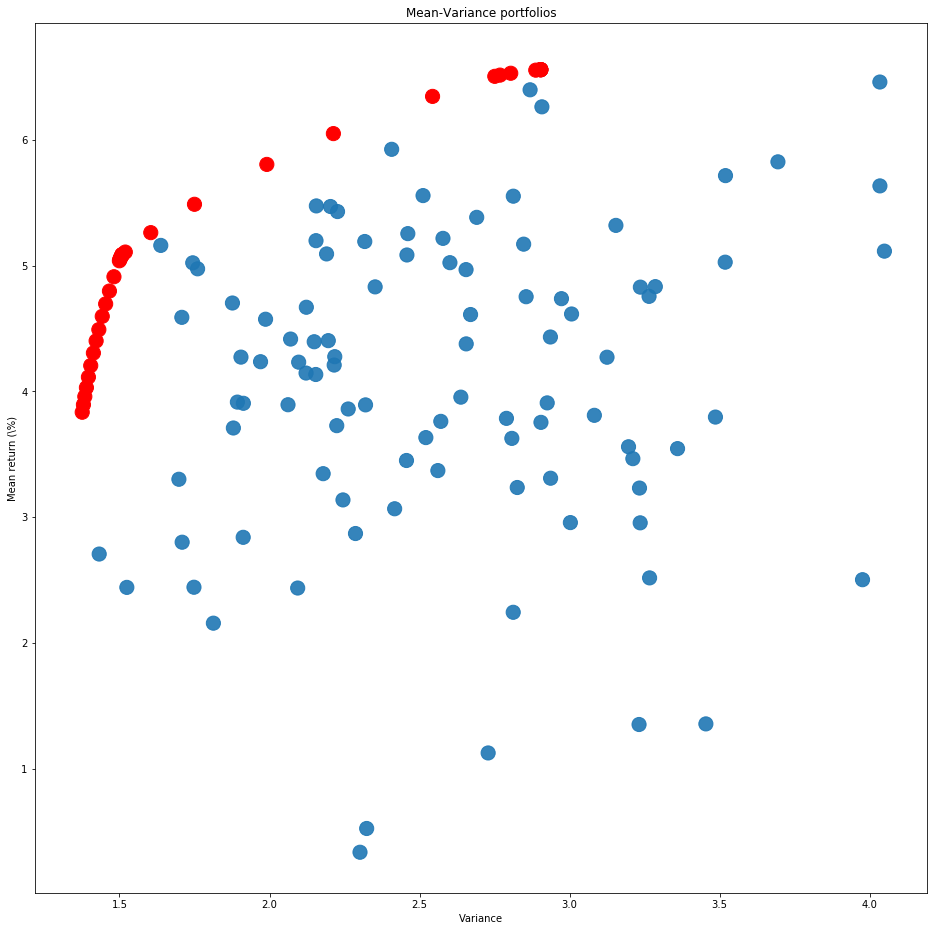

In [53]:
# Initialize plot
fig=plt.figure(figsize=(16,16))

# Plot mean returns and variances of individual assets
plt.scatter([df_input.loc[i,'Variance'] for i in assets], 
            [100*df_input.loc[i,'Mean'] for i in assets], 
            s = 200*np.ones(assets.size),
            alpha=0.9)

for alphaFrontier in [(i/100)**2 for i in range(0,40)]:
    # Construct model with chosen alpha
    m = MeanVarModelConstruction(alphaFrontier,df_input)
    # Optimize
    obj_opt, mean_opt, variance_opt = OptimizeMeanVarModel(m,False)

    # Plot mean returns and variances of new optimal portfolio
    plt.scatter(variance_opt, 
                100*mean_opt, 
                s = 200*np.ones(assets.size),
                c = 'red')

plt.title("Mean-Variance portfolios")
plt.xlabel("Variance")
plt.ylabel("Mean return (\%)")
plt.show()


### Bonus extension question: Short-selling allowed
We are going to introduce two extra variables $x_i^{long} \geq 0$ and $x_i^{short} \geq 0$ that indicate the long and short position in asset $i$. The original variable then becomes a function of the long and short position: $$x_i = x_i^{long} - x_i^{short}, \quad i=1,...,N$$

To comply wth the fictitious regulations set out in this question (total short position cannot be more tan $10\%$ of total long position), we introduce the constraint: $$\sum_{i=1}^Nx_i^{short} \leq 0.1\sum_{i=1}^Nx_i^{long}.$$

In [10]:
# Function that creates model with short selling allowed
def MeanVarModelWithShortSellingConstruction(alpha,df_input):
    # Create model
    m = ConcreteModel()

    # Variables
    m.amount = Var(assets)

    # Add variables for long and short positions
    m.long = Var(assets)
    m.short = Var(assets)
    
    # Objective
    m.value = Objective(
        expr=sum(m.amount[i]*df_input.loc[i,'Mean'] for i in assets)
        - alpha * sum(df_input.loc[i,j]*m.amount[i]*m.amount[j] for i in assets for j in assets)
        , sense = maximize
                 )
    # Constraints on budget
    m.budget = Constraint(expr=sum(m.amount[i] for i in assets) == 1)

    # Short selling constraint (1)
    m.short_selling = ConstraintList()
    for i in assets:
        m.short_selling.add(m.amount[i] == m.long[i] - m.short[i]) # actual position is long - short
        m.short_selling.add(m.long[i] >= 0)
        m.short_selling.add(m.short[i] >= 0)
    
    # Short selling constraint (2)
    m.short_selling_total = ConstraintList()
    m.short_selling.add(sum(m.short[i] for i in assets) <= 0.1/0.9)         # Short position cannot be more than 10% of the long position

    return m

### Solve model with short selling

In [11]:
# Take the same alpha
m = MeanVarModelWithShortSellingConstruction(alpha,df_input)

# Optimize
obj_opt, mean_opt, variance_opt = OptimizeMeanVarModel(m,True)

print("Objective value model \t= %.3f" % obj_opt)
print("\t Mean return \t= %.3f" % mean_opt)
print("\t Variance \t= %.3f\n" % variance_opt)

print("Assets invested in (and amount):")
print("Portfolio composition:")
for i in assets:
    if (abs(value(m.amount[i])) > 0.001):
        print("\t"+ i + " : \t" + str(value(m.amount[i]))) 

Risk aversion parameter = 0.012 

Status = optimal 

Objective value model 	= 0.040
	 Mean return 	= 0.064
	 Variance 	= 1.961

Assets invested in (and amount):
Portfolio composition:
	ME1 INV5 : 	0.0494490375963196
	ME2 INV10 : 	-0.11109420580776909
	ME3 INV6 : 	0.23709864443024617
	ME5 INV2 : 	0.33947132036586575
	ME5 INV5 : 	0.012070333556985686
	ME9 INV5 : 	0.4730125841643483


### Show portfolio in plot
Note that *with* short selling we can achieve a higher return.

However, with short-selling there is a potentially unlimited loss, so it could be more risky. These are things that the Mean-Variance Optimization does not take into account. With some extra constraints (such as on the total short selling position), one can try to somewhat limit this risk.

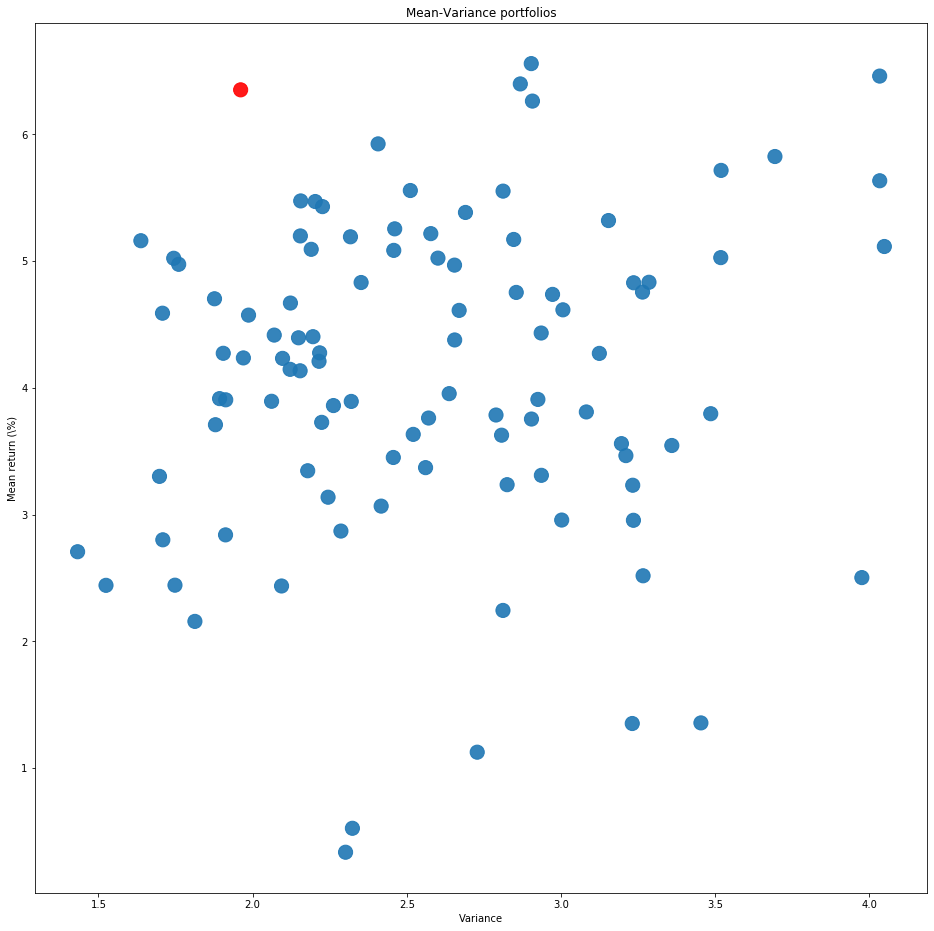

In [12]:
# Initialize plot
fig=plt.figure(figsize=(16,16))

# Plot mean returns and variances of individual assets
plt.scatter([df_input.loc[i,'Variance'] for i in assets], 
            [100*df_input.loc[i,'Mean'] for i in assets], 
            s = 200*np.ones(assets.size),
            alpha=0.9)
# Plot mean returns and variances of new optimal portfolio
plt.scatter(variance_opt, 
            100*mean_opt, 
            s = 200*np.ones(assets.size),
            c = 'red',
            alpha=0.9)

plt.title("Mean-Variance portfolios")
plt.xlabel("Variance")
plt.ylabel("Mean return (\%)")
plt.show()